# AI


## Bibliotecas utilizadas

In [34]:
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx

from helper_functions import Graph, BancoDeHemocentros

## Preparando o problema

### Gerando um grafo da cidade
Vamos come√ßar gerando o grafo da cidade em que nosso sistema vai rodar. No caso, escolhemos a cidade de S√£o Carlos. Com a biblioteca `osmnx`, conseguimos gerar esse grafo e salv√°-lo em um arquivo `.graphml`. Essa biblioteca √© especializada em redes urbanas, utilizando dados geoespaciais reais para gerar um grafo de uma determinada regi√£o.

A classe `Graph` definida em `helper_functions.py` abstrai algumas funcionalidades que iremos precisar mais adiante. Para utilizar  

In [35]:
# # Nome da cidade
# cidade = "S√£o Carlos, S√£o Paulo, Brasil"

# # Baixa o grafo das ruas para transporte por carro (modo drive)
# G = ox.graph_from_place(cidade, network_type='drive')
# ox.save_graphml(G, filepath="sao_carlos.graphml")

N√∫mero de n√≥s: 9042
N√∫mero de arestas: 22340


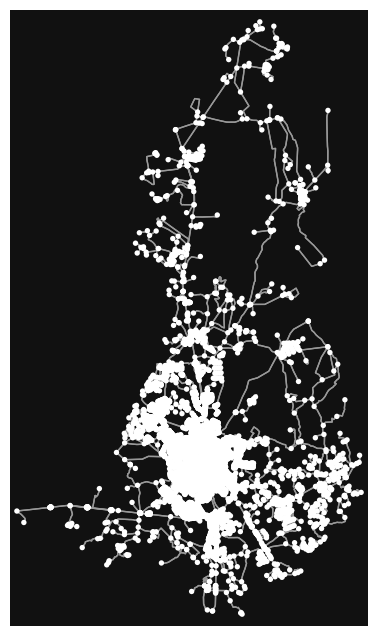

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [36]:
# INSTANCIANDO A CLASSE GRAPH CRIADA
G = Graph("sao_carlos.graphml")

# Mostra informa√ß√µes do grafo
print(f"N√∫mero de n√≥s: {len(G.graph.nodes)}")
print(f"N√∫mero de arestas: {len(G.graph.edges)}")

# Desenha o grafo
ox.plot_graph(G.graph)

Essa √© a carinha do nosso grafo. Para visualiz√°-lo melhor, vamos colocar essa rede em cima do mapa real de S√£o Carlos.

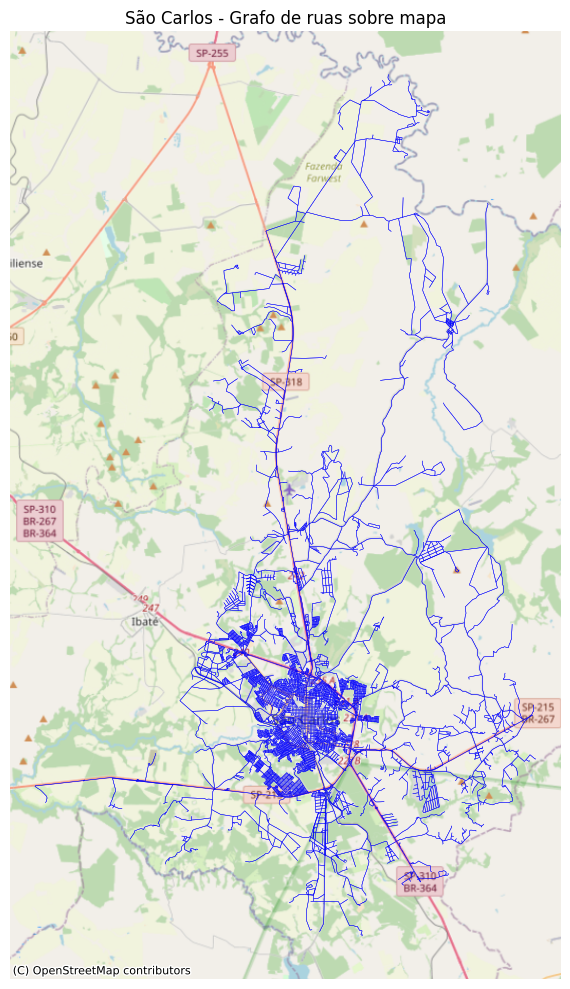

In [37]:
# Plotando as ruas de S√£o Carlos sobre o mapa da cidade
edges = G.edges_gdf

fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue")
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.title("S√£o Carlos - Grafo de ruas sobre mapa")
plt.tight_layout()

plt.savefig("images/sao_carlos_mapa.png", dpi=300)

plt.show()

### Definindo os Hemocentros
Agora que j√° possu√≠mos o grafo da cidade toda de S√£o Carlos, devemos definir onde ficar√£o os `Hemocentros`, que s√£o os n√≥s de interesse do nosso problema de busca (n√≥s finais). Para isso, vamos pegar 7 n√≥s aleat√≥rios, e defini-los como Hemocentros. Na classe j√° existe um m√©todo implementado que retorna n n√≥s aleat√≥rios do grafo, o m√©todo `get_random_nodes()`.

Cada n√≥ do grafo √© salvo com um ID, isto √©, uma String que o identifica. Escolhendo 7 IDs aleat√≥rios, vamos plotar sobre o mapa de S√£o Carlos para visualiz√°-los.

In [38]:
# Pegando 7 n√≥s aleat√≥rios para representar os hemocentros
hemocentros = G.get_random_nodes(7)
print(hemocentros)

# Converte os hemocentros para GDF (somente para poder plotar)
gdf_hemocentros = G.get_gdf_nodes(hemocentros)

[1013705184, 662294871, 1013895189, 491478145, 1000803549, 973865660, 8387113123]


Vamos semelhantemente ao caso anterior plotar os hemocentros sobre o mapa de S√£o Carlos, a fim de obter uma melhor visualiza√ß√£o dos nossos dados. Os c√≠rculos vermelhos no mapa representar√£o a localiza√ß√£o dos hemocentros.

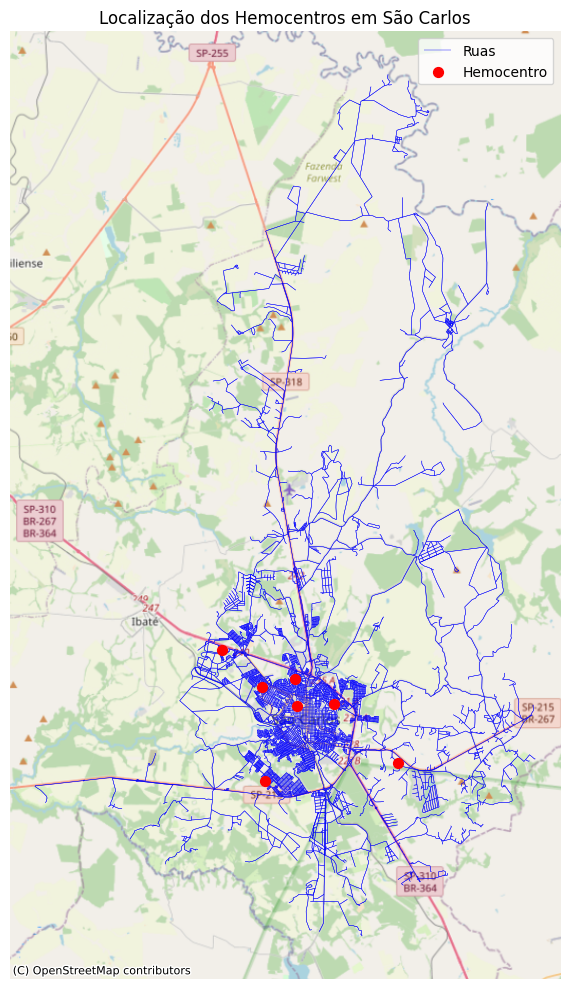

In [39]:
# Plotando o mapa
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localiza√ß√£o dos Hemocentros em S√£o Carlos")
plt.tight_layout()

plt.savefig("images/hemocentros.png", dpi=300)

plt.show()


Precisamos ainda definir o estoque de determinado tipo sangu√≠neo em cada um dos hemocentros. Para isso, vamos usar uma outra classe definida em `helper_functions.py`, a classe `Hemocentros`. Essa classe abstrai todo o estoque de bolsas de sangue de todos os hemocentros da cidade de S√£o Carlos (ou de qualquer cidade que utilize o sistema).

In [40]:
H = BancoDeHemocentros(hemocentros, G.graph)

# Exemplo, estoque de bolsas de sangue um hemocentro
H.consultar_estoque(hemocentros[0])

{'A+': 0, 'A-': 0, 'B+': 12, 'B-': 14, 'AB+': 0, 'AB-': 0, 'O+': 0, 'O-': 11}

### Localiza√ß√£o do Usu√°rio
Agora, que temos os hemocentros dipostos aleatoriamente, precisamos definir a localiza√ß√£o do n√≥ inicial, ou seja, da localiza√ß√£o atual do usu√°rio do sistema. Vamos tamb√©m gerar uma localiza√ß√£o aleat√≥ria para representar o ponto de partida do grafo.

In [41]:
user = G.get_random_nodes(1)
gdf_user = G.get_gdf_nodes(user)

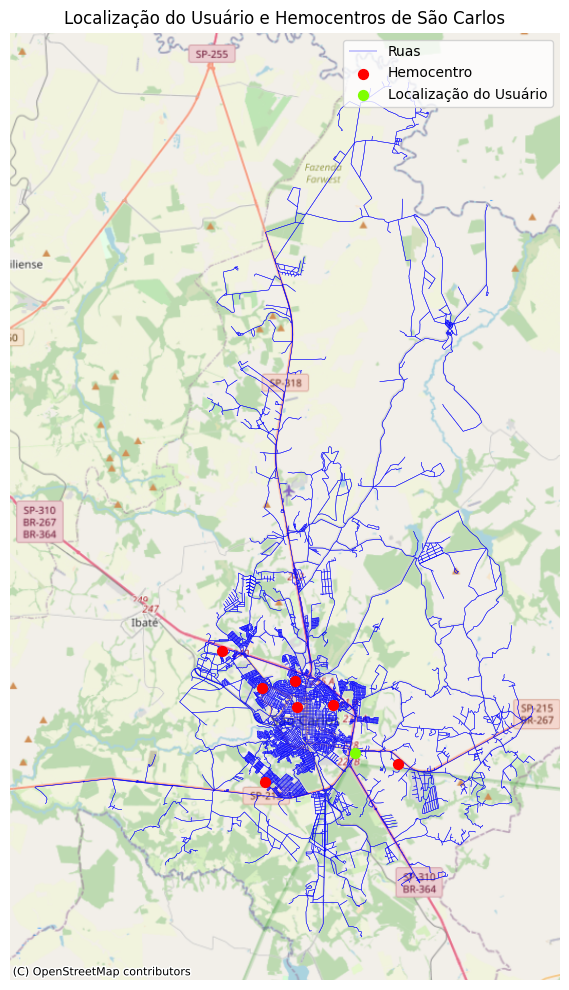

In [42]:
# Plotando o mapa com a localiza√ß√£o aleat√≥ria
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')
gdf_user.plot(ax=ax, color="chartreuse", markersize=50, zorder=3, label='Localiza√ß√£o do Usu√°rio')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localiza√ß√£o do Usu√°rio e Hemocentros de S√£o Carlos")
plt.tight_layout()

plt.savefig("images/usuario.png", dpi=300)

plt.show()

## Buscas: BFS e A*
As duas buscas implementadas para solucionar o problema s√£o a Busca em Largura (ou Breadth-First Search) e o algoritmo A* (A-Estrela). 

Antes de implementar as buscas, o sistema deve ser capaz de identificar atrav√©s do banco de dados quais hemocentros possuem os tipos sangu√≠neos doadores compat√≠veis com o do usu√°rio. Assim, deve-se filtrar os hemocentros que n√£o atendem √†s necessidades antes de realizar a busca.

In [43]:
# Definindo o tipo de sangue do usu√°rio e filtrando os HCs v√°lidos
blood_type = "O-"
hcs_validos = H.hemocentros_validos(blood_type)

print(hcs_validos)

[1013705184, 491478145, 1000803549]


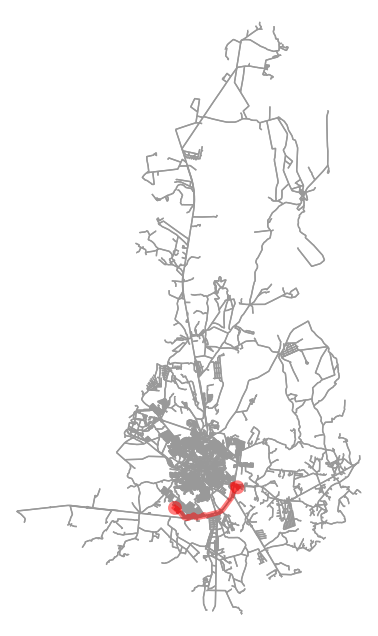

In [44]:
# Teste da fun√ß√£o j√° implementada, n√£o usar
rota = G.calcular_rota(user[0], hcs_validos[0])
G.plotar_rota(rota)

### Busca n√£o informada: BFS (Breadth-First Search)
A Busca em Largura √© a mais adequada quando o assunto √© salvar vidas. Nesse problema, n√£o estamos interessados em qualquer caminho, e sim no mais curto, ou nos mais curtos. 

No entanto, sabemos que, diferentemente de algoritmos que levam pesos e heur√≠sticas em considera√ß√£o, no BFS n√£o somos capazes de dizer se de fato estamos percorrendo a menor dist√¢ncia! Isso parece contraintuitivo, mas na verdade √© bem n√≠tido.

O BFS encontrar√° o menor caminho em termos de arestas percorridas, mas isso n√£o necessariamente garantir√° que ser√° a menor dist√¢ncia, j√° que n√£o consideramos o peso das arestas. Considera√ß√µes nessa estirpe n√£o s√£o resolvidas aqui, mas ser√£o feitas no algoritmo A*.

In [45]:
G.graph.nodes[user[0]]

{'y': -22.0381197, 'x': -47.8574588, 'street_count': 3}

Criamos o arquivo `busca_nao_informada.py`, que cont√©m a implementa√ß√£o da busca em largura, a partir da fun√ß√£o `rota_bfs` que ir√°:

- Receber o grafo (NetworkX)
- Receber um n√≥ de origem
- Receber uma lista de n√≥s de destino (v√°rios hemocentros compat√≠veis)
- Retornar o primeiro caminho mais curto at√© algum deles

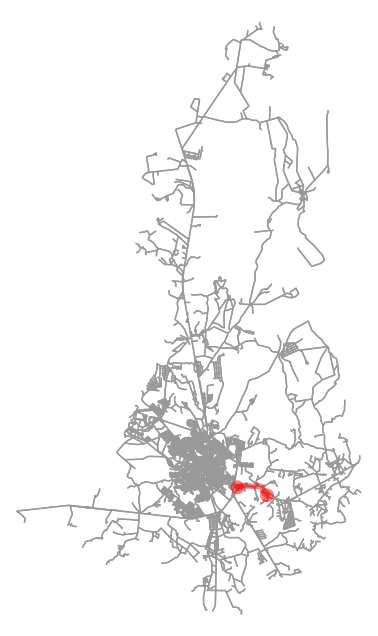

In [ ]:
from busca_nao_informada import bfs

rota_bfs = bfs(G.graph, user[0], hcs_validos)

if rota_bfs:
    G.plotar_rota(rota_bfs)
    G.plotar_rota_com_zoom(bfs)

else:
    print("Nenhum hemocentro acess√≠vel foi encontrado.")


A seguir estamos fazendo uma compara√ß√£o entre nossa implementa√ß√£o da BFS e o algoritmo padr√£o da biblioteca networkx, que faz uma busca cuja pondera√ß√£o √© baseada no peso "length", que s√£o as dist√¢ncias em metros mesmos fornecidas pelo OSM. A `rota_curta` √© de fato a rota mais curta em metros, enquanto `rota_bfs` √© a rota mais curta em n√∫mero de arestas.

In [47]:
import networkx as nx

# Calcula rota √≥tima com menor dist√¢ncia em metros (j√° usa weight='length')
rota_curta = G.calcular_rota(user[0], hcs_validos[0])  # usa nx.shortest_path com peso

# Calcula rota BFS (n√£o ponderada, menor n√∫mero de n√≥s)
from busca_nao_informada import bfs
rota_bfs = bfs(G.graph, user[0], hcs_validos)

# Mostra quantos n√≥s foram usados em cada rota
print(f"üî¥ Rota BFS: {len(rota_bfs)} n√≥s")
print(f"üü¢ Rota com menor dist√¢ncia (curta): {len(rota_curta)} n√≥s")

# Compara se as rotas s√£o iguais ou diferentes
if rota_bfs == rota_curta:
    print("‚úÖ BFS encontrou a mesma rota da menor dist√¢ncia (coincid√™ncia rara).")
else:
    print("‚ö†Ô∏è BFS encontrou uma rota diferente da mais curta em dist√¢ncia ‚Äî esperado!")


üî¥ Rota BFS: 20 n√≥s
üü¢ Rota com menor dist√¢ncia (curta): 96 n√≥s
‚ö†Ô∏è BFS encontrou uma rota diferente da mais curta em dist√¢ncia ‚Äî esperado!


Olha que interessante!

O resultado acima mostra que a rota BFS, que encontra a solu√ß√£o que passa por menos arestas (isto √©, d√° menos saltos) n√£o coincide com a solu√ß√£o que √© de fato, mais curta, em termos de dist√¢ncia (em metros mesmo!). Isso era de se esperar e mostra de maneira cabal que essa busca BFS, assim como a DFS (buscas n√£o informadas no geral) n√£o s√£o adequadas para esse problema, que lida com vidas humanas.

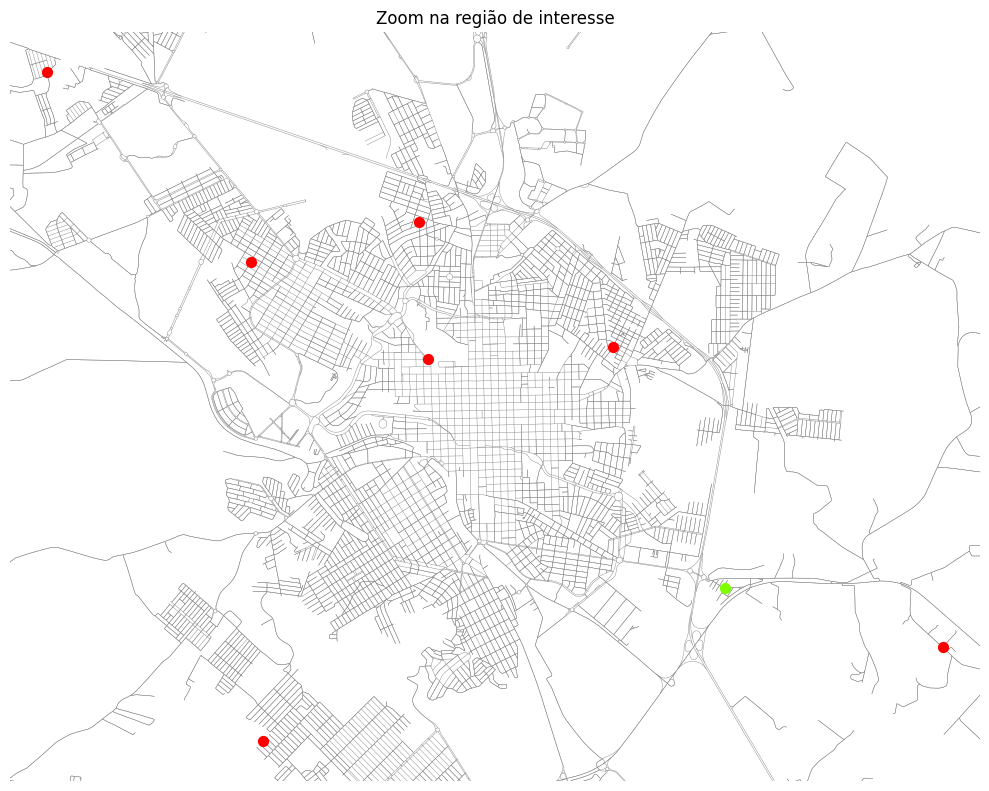

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Agrupa todos os pontos importantes (hemocentros + usu√°rio)
import geopandas as gpd
pontos = gpd.GeoDataFrame(pd.concat([gdf_hemocentros, gdf_user]))

# Calcula limites da regi√£o com margem (padding)
margem = 0.005  # grau de latitude/longitude (~500m de margem)
xmin, ymin, xmax, ymax = pontos.total_bounds
xlim = (xmin - margem, xmax + margem)
ylim = (ymin - margem, ymax + margem)

# Plotando com zoom focado
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="gray")
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3)
gdf_user.plot(ax=ax, color="chartreuse", markersize=50, zorder=3)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.title("Zoom na regi√£o de interesse")
plt.axis("off")
plt.tight_layout()
plt.show()


### Busca Informada: A* (A-Star)
O algoritmo A* (A-Estrela) de busca em grafos √© um tipo de busca informada, no qual utiliza-se de uma heur√≠stica...